# Geo data

<div class="admonition note">
    <p class="admonition-title">In progress</p>
    <p>This document is a work in progress if you see any errors, or exclusions or have any problems, please <a href="https://github.com/absespy/ABSESpy/issues">get in touch with us</a>.</p>
</div>

This notebook shows how to work with geographic spatial datasets.

<!-- Download the data from [here](https://www.kaggle.com/c/tweet-sentiment-extraction/data) and place it in the `data` directory. -->

## Setup Geo spatial area

In `yaml` settings file, when assigning the `world` parameter of a `nature` module as a path of map, module will automatically read this map as the "basemap".

```yaml
world: data/mean_prec.tif
```


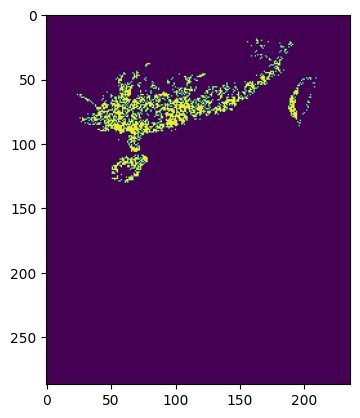

In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import rasterio

# data path
data_folder = Path("data/")
data_folder.exists()
data = data_folder / "farmland.tif"

# read dataset
with rasterio.open(data) as src:
    img = src.read(1)
plt.imshow(img)

[2024-03-20 18:43:34][human          ] | Initializing a new Human Module...
[2024-03-20 18:43:34][nature         ] | Initializing a new Base Nature module...
[2024-03-20 18:43:34][nature         ] | Initializing a new Model Layer...
[2024-03-20 18:43:34][nature         ] | Using rioxarray version: 0.13.4


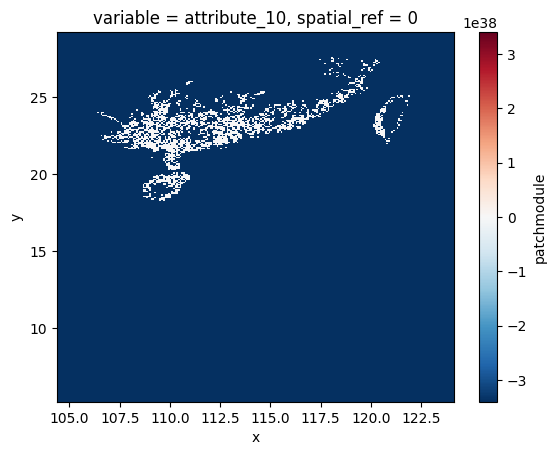

In [2]:
from abses import MainModel

# default model
model = MainModel()

sub_module = model.nature.create_module(how="from_file", raster_file=data)

# plotting
sub_module.get_xarray().plot()